In [18]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.time import Time
import os
from scipy.signal import lombscargle


from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker
output_notebook()


from gatspy.periodic import LombScargleFast, LombScargle


import matplotlib.pyplot as plt
%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

Loading BokehJS ...

In [28]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



def getvegamaganddates(data,columnfile,name):
    vegamagindex = np.arange(28,6568,13)
    
    
    vegamaglist = np.array([float(data[i]) for i in vegamagindex])
    vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])
    
    columns = []
    with open(columnfile) as filecol:
        for line in filecol:
            columns.append(line)
    listanames = []
    dates = []
    times =[]
    nameobject = []
    namel=[]

    for i in vegamagindex:
        initname = columns[i].find('Try/u')
        namefits = columns[i][initname:initname+23]
        listanames.append(namefits)
        fit = fits.open(namefits+'.fits')
        dates.append(fit[0].header['DATE-OBS'])
        times.append(fit[0].header['TIME-OBS'])
        namel.append(name)
    datesobs = [['{}T{}'.format(i,j)] for i,j in zip(dates,times)]

    d = np.array(datesobs)
    t = Time(d)
    namel = np.array(namel)
       
    return vegamaglist, vegamaglisterrors,t, d, namel


def createdatadiccomplete(data,columnfile):
    vegamag,vegamagerrros, timelist, observationname = getvegamaganddates(data,columnfile)
    datadic = {'time':timelist.datetime64,
               'VEGAMAG':vegamag,
               'obnames':observationname,
                'errorsmag':vegamagerrros}
    return datadic
            
def createdatadicclean(datafile,index,columnfile,name='name'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)

    datadic = {'time':timelist.datetime64[goodvegamagindex],
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic


def createdatadicclean(datafile,index,columnfile,name='name',timeformat='datetime64'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)
    if timeformat == 'datetime64':
        timelist2 = timelist.datetime64[goodvegamagindex]
    elif timeformat == 'mjd':
        timelist2 = timelist.mjd[goodvegamagindex]

    datadic = {'time':timelist2,
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic


def plotlb(outputfile,index,columnfile,name='',plot=True,getarg=False,periods=np.linspace(0.2, 1.4, 4000)):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

        # Choose a period grid
    periods = periods
    #periods = np.linspace(0.2, 1.4, 4000)
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    power = lombscargle(t.flatten(), mag - mag.mean(), ang_freqs,normalize=False)

    # normalize the power
    N = len(t.flatten())
    #power *= 2 / (N * mag.std() ** 2)
    if plot == True:
        # plot the results
        fig, ax = plt.subplots()
        ax.plot(periods, power)
        ax.set(ylim=(0, 0.8), xlabel='period (days)',
               ylabel='Lomb-Scargle Power');
    if getarg == True:
        return periods, power,t,mag,dmag

def plotlc(outputfile,indexlist,columnfile,namelist=''):
    colorlist = ['red','blue','green','yellow']
    p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
                  x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')
    
    
    for i,indexnumber in enumerate(indexlist):
        color = colorlist[i]
        
        datagood = createdatadicclean(outputfile,indexnumber,columnfile,name=namelist[i])

        source = ColumnDataSource(data=datagood)
   


        


        #Tool to get wavelength
        hover2 = HoverTool(
                tooltips=[
                    ('Date', '(@obnames)')
                ]
            )


        p.add_tools(hover2)



        # add a circle renderer with a size, color, and alpha
        p.circle('time','VEGAMAG', source=source, color=color, name='name',legend='name')
        p.add_layout(
            Whisker(source=source, base="time", upper="upper", lower="lower")
        )






    show(p)

def plotphase(outputfile,index,columnfile,name='',plot=False,periodmax=99.99):
    nameob= name
    periods,power,t,mag,dmag = plotlb(outputfile,index,columnfile,name=nameob,plot=plot,getarg=True)
    #datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    #t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']
    indexmax = np.where(power == power.max())
    if periodmax == 99.99:
        periodmax = periods[indexmax]
    print(periodmax)

    # Compute phases of the obsevations
    phase = (t.flatten() / periodmax) % 1

    # Plot the phased data & model
    fig, ax = plt.subplots()

    
    ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
    ax.invert_yaxis();
    plt.show()
    
    
def plotlcseaborn(outputfile,index,columnfile,name='',invertaxis = False):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

    
    
    fig, ax = plt.subplots()


    ax.errorbar(t, mag, dmag,  fmt='.k', ecolor='gray')
    ax.set(xlabel='Time (days)', ylabel='magitude',
           title=datagoodmjd['name'][0])
    if invertaxis == True:
        ax.invert_yaxis();
    plt.show()

In [29]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'

# 1179 U23

In [30]:
plotlc(outputfile,[1179],columnfile,namelist=['1179'])
plotlcseaborn(outputfile,1179,columnfile,name='1179')
datagoodmjd=  createdatadicclean(outputfile,1179,columnfile,name='1179',timeformat='mjd')
t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']


sed '1180q;d'  outdir/out.photo
['520.61', '248.53']


sed '1180q;d'  outdir/out.photo
['520.61', '248.53']


FigureCanvasNbAgg()

sed '1180q;d'  outdir/out.photo
['520.61', '248.53']


In [31]:
plotlb(outputfile,1179,columnfile,name='1179',periods=np.linspace(0.2, 0.5, 40000))
plotphase(outputfile,1179,columnfile,name='1179')

sed '1180q;d'  outdir/out.photo
['520.61', '248.53']


FigureCanvasNbAgg()

sed '1180q;d'  outdir/out.photo
['520.61', '248.53']
[0.23540885]


FigureCanvasNbAgg()

# With gatspy

In [19]:
%matplotlib widget

# Choose a period grid
periods = np.linspace(0.01, 1.4, 40000)
ang_freqs = 2 * np.pi / periods


fmin = 1. / periods.max()
fmax = 1. / periods.min()
N = 10000
df = (fmax - fmin) / N

model = LombScargle().fit(t.flatten(), mag, dmag)
power = model.score_frequency_grid(fmin, df, N)
freqs = fmin + df * np.arange(N)

# plot the results
fig, ax = plt.subplots()
ax.plot(1. / freqs, power)
ax.set(ylim=(0, 0.8),xlim=(0,1), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

FigureCanvasNbAgg()

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0475
 - User-specified period range:  0.05 to 1
 - Computing periods at 2515 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 0.06446146485003532


[]

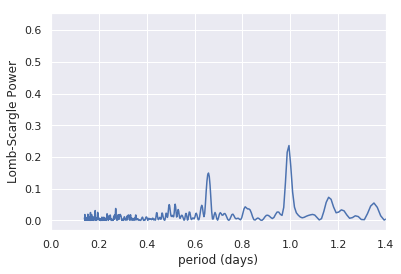

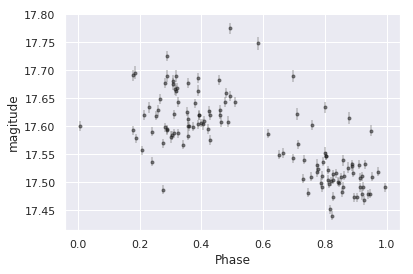

In [17]:
model = LombScargle().fit(t.flatten(), mag, dmag)
periods, power = model.periodogram_auto()
#periods, power = model.periodogram_auto()

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 1.4),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');



# set range and find period
model.optimizer.period_range=(0.05, 1)




period = model.best_period
print("period = {0}".format(period))

# Compute phases of the obsevations
phase = (t.flatten() / period) % 1

# Plot the phased data & model
fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.set(xlabel='Phase', ylabel='magitude')
#ax.invert_yaxis();
plt.plot()

# U18

In [34]:
plotlc(outputfile,[737],columnfile,namelist=['737'])
plotlcseaborn(outputfile,737,columnfile,name='737')
datagoodmjd=  createdatadicclean(outputfile,737,columnfile,name='737',timeformat='mjd')
t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']


plotlb(outputfile,737,columnfile,name='737',periods=np.linspace(0.08, 106, 40000))
plotphase(outputfile,737,columnfile,name='737',periodmax=1.9)

sed '738q;d'  outdir/out.photo
['515.39', '125.65']


sed '738q;d'  outdir/out.photo
['515.39', '125.65']


FigureCanvasNbAgg()

sed '738q;d'  outdir/out.photo
['515.39', '125.65']
sed '738q;d'  outdir/out.photo
['515.39', '125.65']


FigureCanvasNbAgg()

sed '738q;d'  outdir/out.photo
['515.39', '125.65']
[0.99579895]


FigureCanvasNbAgg()

In [36]:
plotphase(outputfile,737,columnfile,name='737',periodmax=1.96)

sed '738q;d'  outdir/out.photo
['515.39', '125.65']
1.96


/home/mmarcano/anaconda3/envs/muse/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0475
 - User-specified period range:  0.05 to 1
 - Computing periods at 2515 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 0.06446146485003532
0.06446146485003532


[]

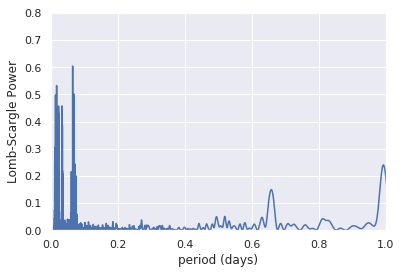

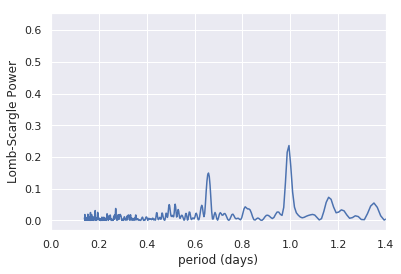

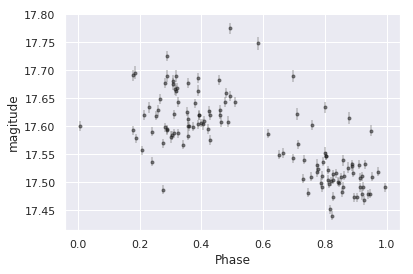

In [9]:



# Choose a period grid
periods = np.linspace(0.01, 1.4, 4000)
ang_freqs = 2 * np.pi / periods


fmin = 1. / periods.max()
fmax = 1. / periods.min()
N = 100000
df = (fmax - fmin) / N

model = LombScargleFast().fit(t.flatten(), mag, dmag)
power = model.score_frequency_grid(fmin, df, N)
freqs = fmin + df * np.arange(N)

# plot the results
fig, ax = plt.subplots()
ax.plot(1. / freqs, power)
ax.set(ylim=(0, 0.8),xlim=(0,1), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');



model = LombScargle().fit(t.flatten(), mag, dmag)
periods, power = model.periodogram_auto()
#periods, power = model.periodogram_auto()

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 1.4),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');



# set range and find period
model.optimizer.period_range=(0.05, 1)




period = model.best_period
print("period = {0}".format(period))

# Compute phases of the obsevations
phase = (t.flatten() / period) % 1
print(period)
# Plot the phased data & model
fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.set(xlabel='Phase', ylabel='magitude')
#ax.invert_yaxis();
plt.plot()

In [ ]:
data = getobjectdata(outputfile,737)

vegamagindex = np.arange(28,6568,13)


vegamaglist = np.array([float(data[i]) for i in vegamagindex])
vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])

photometricflag = np.array([float(data[i+8]) for i in vegamagindex])
snr = np.array([float(data[i+4]) for i in vegamagindex])


columns = []
with open(columnfile) as filecol:
    for line in filecol:
        columns.append(line)

columns = np.array(columns)